In [35]:
import time
import pickle
from hnsw.hnsw import HNSW
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

In [6]:
def generate_data(
    num_atoms: int = 10**3,
    len_signal: int = 10**4,
    num_signals: int = 1,
    num_best_atoms: int =5,
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:

	
    rng = np.random.default_rng(seed)
    atoms_array = np.empty((num_atoms, len_signal))
    means = rng.normal(size=num_atoms)
    atoms_array = np.empty((num_atoms, len_signal))
    for idx in range(num_atoms):
      atoms_array[idx] = rng.normal(loc=means[idx], size=len_signal)
    signal = rng.normal(loc=rng.normal(), size=(num_signals, len_signal))
    if num_signals == 1:
        signal = signal.reshape(1,-1)

    return atoms_array, signal

In [37]:
def sample_complexity(dimension):
    
    top_k = 50

    atoms, signal = generate_data(num_atoms=1000, len_signal=dimension, num_best_atoms=top_k)
    
    hnsw = HNSW('cosine', m0=16, ef=128)
    for i in range(len(atoms)):
        hnsw.add(atoms[i])


    # save index
    with open('glove.ind', 'wb') as f:
        picklestring = pickle.dump(hnsw, f, pickle.HIGHEST_PROTOCOL)

    # load index
    fr = open('glove.ind','rb')
    hnsw_n = pickle.load(fr)

    add_point_time = time.time()
    idx = hnsw_n.search(signal, top_k)
    search_time = time.time() - add_point_time

    
    
    return search_time

In [ ]:


dim = 200
num_elements = 100
top_k = 10

atoms, signal = generate_data(num_atoms=1000, len_signal=200)


hnsw = HNSW('cosine', m0=16, ef=128)

for i in range(len(atoms)):
    hnsw.add(atoms[i])


# save index
with open('glove.ind', 'wb') as f:
    picklestring = pickle.dump(hnsw, f, pickle.HIGHEST_PROTOCOL)

# load index
fr = open('glove.ind','rb')
hnsw_n = pickle.load(fr)

add_point_time = time.time()
idx = hnsw_n.search(signal, top_k)
search_time = time.time() - add_point_time
candidates = [k[0] for k in idx]
print("Searchtime: %f" % (search_time ))
print(f"top {top_k} from hnsw:{candidates}")

Searchtime: 0.006575
top 10 from hnsw:[691, 190, 51, 69, 616, 176, 12, 478, 775, 98]


In [43]:
num_best_atoms =10

begin = time.time()
naive_candidates_array = (
                np.matmul(atoms, signal.transpose())
                .argsort(axis=0)[:num_best_atoms]
                .transpose()
            )
naive_time = time.time() - begin 

print(naive_candidates_array)

print(f"time taken by naive search:{naive_time}")

intersection = np.intersect1d(candidates, naive_candidates_array[0])
precision = len(intersection)
speedup = naive_time/search_time
print(f"precision={precision*100/top_k} percent\nspeedup over naive search = {speedup}")

[[478 303 616  69 948 413 284 238  12 982]]
time taken by naive search:0.010150909423828125
precision=40.0 percent
speedup over naive search = 1.5437833133906234


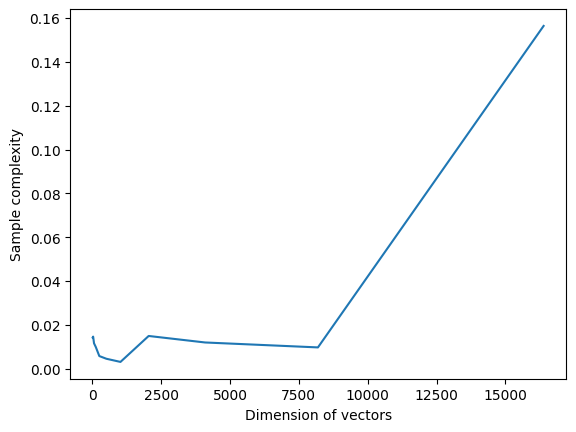

In [41]:
# plotting sample complexity plot

dimensions = [2**i for i in range(4,15)]
sample_comp  = []
for dimension in dimensions:
    sample_comp.append(sample_complexity(dimension))

plt.plot(dimensions,sample_comp)
plt.xlabel("Dimension of vectors")
plt.ylabel("Sample complexity")

plt.show()

Movie Lens Dataset

In [48]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Load the MovieLens dataset (100k version for simplicity)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_builtin('ml-1m')
trainset, testset = train_test_split(data, test_size=0.2)

# Build a user-item matrix
user_item_matrix = np.zeros((trainset.n_users, trainset.n_items))
for uid, iid, rating in trainset.all_ratings():
    user_item_matrix[int(uid), int(iid)] = rating

# Use SVD to reduce dimensionality
svd = TruncatedSVD(n_components=50)
atoms = svd.fit_transform(user_item_matrix.T)  # Transpose to get item embeddings

# Create a signal (simulate a user's preference vector)
user_id = 0  # Choose a user ID from the dataset
user_ratings = user_item_matrix[user_id]
signal = np.dot(user_ratings, atoms)  # Weighted average of rated item embeddings
signals = signal[np.newaxis, :]  # Ensure signal has 2D shape for batch processing


num_best_atoms = 10  # Top-k items to retrieve

# Run hnsw MIPS
hnsw = HNSW('cosine', m0=24, ef=200)

for i in range(len(atoms)):
    hnsw.add(atoms[i])


# save index
with open('glove.ind', 'wb') as f:
    picklestring = pickle.dump(hnsw, f, pickle.HIGHEST_PROTOCOL)

# load index
fr = open('glove.ind','rb')
hnsw_n = pickle.load(fr)

add_point_time = time.time()
idx = hnsw_n.search(signal, top_k)
search_time = time.time() - add_point_time
candidates = [k[0] for k in idx]

# Output results
print(f"Top {num_best_atoms} candidates (indices):\n{candidates}")
print(f"search time: {search_time}")

# Naive approach for validation
begin = time.time()
inner_products = np.dot(atoms, signal)
top_k_naive = np.argsort(inner_products)[num_best_atoms:]
naive_time = time.time()-begin
print(f"Top {num_best_atoms} candidates using naive approach (indices): {top_k_naive}")

# Compare results
accuracy = len(np.intersect1d(candidates, top_k_naive)) / num_best_atoms
print(f"Accuracy compared to naive method: {accuracy * 100:.2f}%")

# Compute speedup ratio
speedup_ratio = search_time / naive_time
print(f"Speedup ratio: {speedup_ratio:.2f} times faster than naive computation.")

Top 10 candidates (indices):
[2831, 3524, 3667, 3179, 3485, 3504, 3604, 3679, 3666, 3436]
search time: 0.008379697799682617
Top 10 candidates using naive approach (indices): [3666 3426 3524 ...   75  851  183]
Accuracy compared to naive method: 50.00%
Speedup ratio: 10.81 times faster than naive computation.
